This notebook contains a detailed description of the data cleaning process and the exploratory data analysis (EDA) of the original data.<br><br> 
The **goal** of this analysis is to select or engineer features that can be used to predict fraud. <br> These features will be summarized in a new data frame that can be used for modelling. 

**Contents**

---

1. [**Import Libraries**](#1-import-libraries)
2. [**Get Data**](#get_data)
    *   data description 
    *   `df_client`: client data
    *   `df_invoice`: client invoice data 
3. [**Data Cleaning**](#3-data-cleaning)
    *   [renaming](#renaming)
    *   check [missing values](#missing-values)
    *   check [duplicates](#duplicates)
    *   [data type conversions](#data-type-conversions)
4. [**Exploring Features**](#4-eda---data-exploration)

---

# 1. Import libraries 

In [1]:
import os
import sys
from dotenv import load_dotenv

import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get variables from .env file 
load_dotenv()
project_path = os.getenv('PROJECT_PATH')

# add path to load own functions from .py files in Scrips folder
sys.path.insert(0, project_path + '\Scripts')

from plotting import *
from preprocessing import *


In [3]:
# colors
COLOR_1 = 'steelblue'
RED_COLORS = ['#e3868d', '#E42A38', '#8a010b']  # bright, middle, dark

# fraud values for plots and grouping 
FRAUD_BASELINE:float    # defined at beginning of 4.EDA  
FRAUD_RANGE = 1.5       # +/- range from baseline considered "normal" fraud rate

# list of column names that are used for modelling
CAT_FEATURES = []
NUM_FEATURES = []

<a id='get_data'></a>

# 2. Get data

[Data description](../data/data_description.md)

In [4]:
# import csv data to pandas dataframes
df_client = pd.read_csv('../data/files/client_train.csv', parse_dates=['creation_date'], dayfirst=True, low_memory=False)
df_invoice = pd.read_csv('../data/files/invoice_train.csv', parse_dates=['invoice_date'], dayfirst=False, low_memory=False)

# Dimensions of dfs
print(f'The client data frame has {df_client.shape[0]} rows and {df_client.shape[1]} columns.')
print(f'The invoice data frame has {df_invoice.shape[0]} rows and {df_invoice.shape[1]} columns.')

The client data frame has 135493 rows and 6 columns.
The invoice data frame has 4476749 rows and 16 columns.


In [5]:
df_client.head(2)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,1994-12-31,0.0
1,69,train_Client_1,11,107,2002-05-29,0.0


In [6]:
df_invoice.head(2)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC


# 3. Data cleaning

## Renaming

In [7]:
# rename columns
df_client.rename({'disrict': 'district',
                  'client_catg': 'client_category'
                  }, axis=1, inplace=True)

df_invoice.rename({'counter_statue': 'counter_status',
                   'reading_remarque': 'remark',
                   'counter_coefficient': 'counter_coeff',                   
                   }, axis=1, inplace=True)

# rename 'consommation' features 1 to 4 to consumption
for i in range(1,5):
   df_invoice.rename({f'consommation_level_{i}': f'consumption_lvl_{i}'}, axis=1, inplace=True)
                      
# remove client_id prefix from observations in client_id column
if isinstance(df_invoice['client_id'][0], str):
   df_invoice['client_id'] = df_invoice.client_id.str.removeprefix('train_Client_').astype(int)
   df_client['client_id'] = df_client.client_id.str.removeprefix('train_Client_').astype(int)

df_client.head(2)

,district,client_id,client_category,region,creation_date,target
0,60,0,11,101,1994-12-31,0.0
1,69,1,11,107,2002-05-29,0.0


## Missing values

In [8]:
# check for missing values
na_client = df_client.isna().sum().sum()
na_invoice = df_invoice.isna().sum().sum()
print(f'There are {na_client} missing values in the client data and {na_invoice} missing values in the invoice data.')

There are 0 missing values in the client data and 0 missing values in the invoice data.


## Duplicates

In [9]:
# check for duplicated values
dupes_client = df_client.duplicated().sum()
dupes_invoice = df_invoice.duplicated().sum()
print(f'There are {dupes_client} duplicated values in the client data and {dupes_invoice} duplicated values in the invoice data.')


There are 0 duplicated values in the client data and 11 duplicated values in the invoice data.


In [10]:
# remove duplicated values and check again
df_invoice.drop_duplicates(inplace=True)
df_invoice.duplicated().sum()

0

## Data type conversions

Check the data type (numeric, categorical) and the format (str, int, float) of the values in each column and do conversions where necessary. <br><br>

**Workflow**

---
1.  Check data type of each column with `.info()`
2.  Check number of unique values for each column with `.nunique()`
    - A small number of unique values (usually) indicates a categorical variable
    - A large number of unique values (usually) indicates a numerical variable
    - To be sure look at the unique values
3. Do data type conversion using the function `convert_column_type` from `preprocessing.py` in Scripts directory
    - first convert column data types to int/str
    - then convert column data to categorical if necessary
* Converting a string variable to a categorical variable will save some memory


### Client data

In [11]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   district         135493 non-null  int64         
 1   client_id        135493 non-null  int32         
 2   client_category  135493 non-null  int64         
 3   region           135493 non-null  int64         
 4   creation_date    135493 non-null  datetime64[ns]
 5   target           135493 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3)
memory usage: 5.7 MB


In [12]:
# getting unique values for each column to get an idea about numerical/categorical features
df_client.nunique()

district                4
client_id          135493
client_category         3
region                 25
creation_date        8088
target                  2
dtype: int64

All features (except the creation_date) will be converted to categorical type.

In [13]:
# step 1: convert to str
cols_to_str = ['district', 'client_category', 'region', 'client_id']
df_client = convert_column_type(df_client, cols_to_str, str)

# step 1: convert to int
df_client = convert_column_type(df_client, 'target', int)

# step 2: convert to category
df_client = convert_column_type(df_client, cols_to_str, 'category') # for percentage calculations 
df_client = convert_column_type(df_client, 'target', 'category')

# check conversions
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   district         135493 non-null  category      
 1   client_id        135493 non-null  category      
 2   client_category  135493 non-null  category      
 3   region           135493 non-null  category      
 4   creation_date    135493 non-null  datetime64[ns]
 5   target           135493 non-null  category      
dtypes: category(5), datetime64[ns](1)
memory usage: 7.1 MB


### Invoice data

In [14]:
df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4476738 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   client_id          int32         
 1   invoice_date       datetime64[ns]
 2   tarif_type         int64         
 3   counter_number     int64         
 4   counter_status     object        
 5   counter_code       int64         
 6   remark             int64         
 7   counter_coeff      int64         
 8   consumption_lvl_1  int64         
 9   consumption_lvl_2  int64         
 10  consumption_lvl_3  int64         
 11  consumption_lvl_4  int64         
 12  old_index          int64         
 13  new_index          int64         
 14  months_number      int64         
 15  counter_type       object        
dtypes: datetime64[ns](1), int32(1), int64(12), object(2)
memory usage: 563.6+ MB


In [15]:
# getting unique values for each column to get an idea about numerical/categorical features
df_invoice.nunique()

client_id            135493
invoice_date           8275
tarif_type               17
counter_number       201893
counter_status           12
counter_code             42
remark                    8
counter_coeff            16
consumption_lvl_1      8295
consumption_lvl_2     12576
consumption_lvl_3      2253
consumption_lvl_4     12075
old_index            155648
new_index            157980
months_number          1370
counter_type              2
dtype: int64

- **Convert to str and category**: <br>['client_id', 'tarif_type', 'counter_status', 'counter_code', 
               'remark', 'counter_coeff', 'old_index', 'new_index', 'counter_type']
- **To be decided**: <br>months_number, counter_number

In [16]:
# step 1: convert to str
cols_to_str = ['client_id', 'tarif_type', 'counter_status', 'counter_code', 
               'remark', 'counter_coeff', 'old_index', 'new_index', 'counter_type']
df_invoice = convert_column_type(df_invoice, cols_to_str, str)

# step 2: convert to category
df_invoice = convert_column_type(df_invoice, cols_to_str, 'category') # for percentage calculations 

df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4476738 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   client_id          category      
 1   invoice_date       datetime64[ns]
 2   tarif_type         category      
 3   counter_number     int64         
 4   counter_status     category      
 5   counter_code       category      
 6   remark             category      
 7   counter_coeff      category      
 8   consumption_lvl_1  int64         
 9   consumption_lvl_2  int64         
 10  consumption_lvl_3  int64         
 11  consumption_lvl_4  int64         
 12  old_index          category      
 13  new_index          category      
 14  months_number      int64         
 15  counter_type       category      
dtypes: category(9), datetime64[ns](1), int64(6)
memory usage: 365.6 MB


# 4. EDA - data exploration

## What is the overall fraud rate in the sample? (Baseline)


There are 135493 clients in the sample.
Of those clients 5.58 % show normal and 94.42 % fraudulent activity 
in electricity and/ or gas consumption.


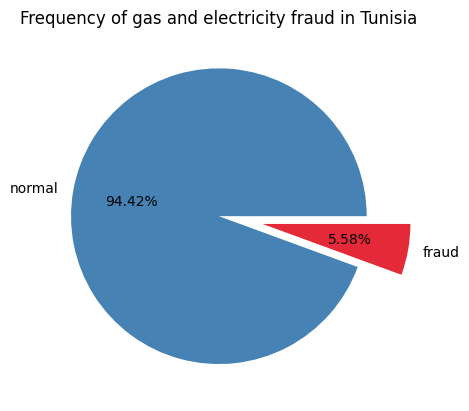

In [17]:
# general information about the data

FRAUD_BASELINE = get_fraud_proportion(df_client) 

print(f'There are {df_client.client_id.nunique()} clients in the sample.')
print(f'Of those clients {round(FRAUD_BASELINE, 2)} % show normal and '
      f'{round(100 - FRAUD_BASELINE, 2)} % fraudulent activity \nin electricity and/ or gas consumption.')

create_fraud_freq_pieplot(df_client)  # function from Scripts/plotting.py

## Explore categorical features

**Goal**: Select or create features to model fraud 

**Workflow**: 
1)    Find out how the categories of a feature are related to fraud
   *   Get an overview with the help of a figure using <br> `subplopts_fraud_per_category()` function from `plotting.py` script <br> <br>
        *   Left subplot: Categorical features are grouped by target 'energy consumption' (normal / fraud)
        *   Right subplot: The fraud rate for each feature category is compared to the overall fraud rate (baseline)

2)   If indicated, create a new categorical feature `fraud_risk` 

*   The fraud_risk feature has 3 levels (0: low, 1: normal, 2: high) created from feature categories <br> in which the fraud rate is smaller, similar or higher compared to the baseline 
*   using `create_fraud_risk_feature()` function from `feature_engineering.py` script

3)  Save the feature names of the features to be used for modeling in `CAT_FEATURES` 

### Feature `region`

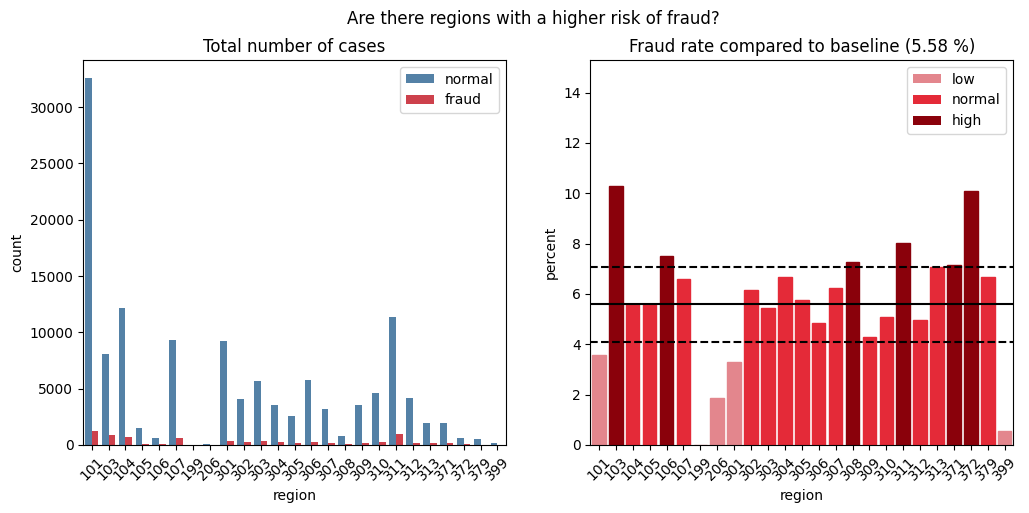

The feature region has 25 categories that are reassigned to the new feature "fraud risk".
"Fraud risk" has 3 levels ('low', 'normal', 'high')
Normal risk is defined within the dashed lines (baseline of 5.58 +/- 1.5).

low: ['101', '301', '206', '399', '199']
normal: ['313', '379', '304', '107', '307', '302', '305', '104', '105', '303', '310', '312', '306', '309']
high: ['103', '372', '311', '106', '308', '371']


In [18]:
# 1. Plotting 
grouped_df_region, risk_categories_region = subplopts_fraud_per_category(df_client, 
                                                                         feature='region', 
                                                                         fraud_baseline=FRAUD_BASELINE, 
                                                                         fraud_range=FRAUD_RANGE, 
                                                                         verbose=True)

Comment:
-   in the plot on the right we can see that some regions have a fraud rate lower, similar or higher than baseline (different shades of red)
-   this can be used to create a new freature where these regions are assigned to the three different fraud risk categories (low, normal, high)

In [19]:
# 2. Create new feature
df_client = create_fraud_risk_feature(df_client, 
                                      feature_in='region', 
                                      new_categories=risk_categories_region, 
                                      verbose=True)
df_client.head(2)


New feature "risk_region" was added to the dataframe.
Higher values indicate a higher risk of fraud.

 Category 0: 32.14%
 Category 1: 48.95%
 Category 2: 18.91%


,district,client_id,client_category,region,creation_date,target,risk_region
0,60,0,11,101,1994-12-31,0,0
1,69,1,11,107,2002-05-29,0,1


In [20]:
# 3. Save feature names for modelling

CAT_FEATURES = add_feature_to_list('risk_region', CAT_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

Categorical features:
['risk_region']

Numerical features:
[]


### Feature `district`

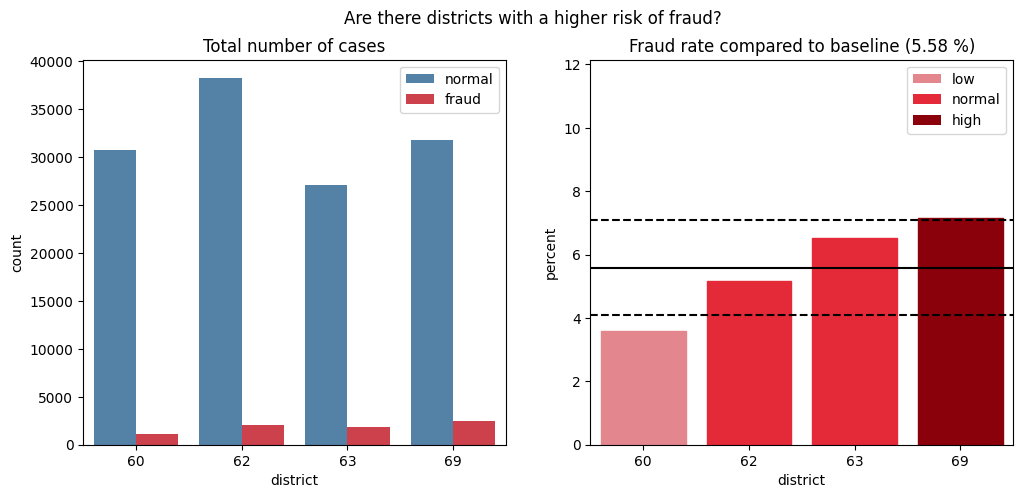

The feature district has 4 categories that are reassigned to the new feature "fraud risk".
"Fraud risk" has 3 levels ('low', 'normal', 'high')
Normal risk is defined within the dashed lines (baseline of 5.58 +/- 1.5).

low: ['60']
normal: ['63', '62']
high: ['69']


In [21]:
# 1. Plotting
grouped_df_district, risk_categories_district  = subplopts_fraud_per_category(df_client, 
                                                                              feature='district', 
                                                                              fraud_baseline=FRAUD_BASELINE, 
                                                                              fraud_range=FRAUD_RANGE, 
                                                                              verbose=True)

Comment:
*   the fraud rate seems to be a little higher than baseline range in district 69 and lower in discrict 60
*   aggregate the districts to a new feature `risk_district` with 3 levels low, normal, high (as above) 

In [22]:
# 2. Create new feature
df_client = create_fraud_risk_feature(df_client, 
                                      feature_in='district', 
                                      new_categories=risk_categories_district, 
                                      verbose=True)
df_client.head(2)


New feature "risk_district" was added to the dataframe.
Higher values indicate a higher risk of fraud.

 Category 0: 23.56%
 Category 1: 51.18%
 Category 2: 25.26%


,district,client_id,client_category,region,creation_date,target,risk_region,risk_district
0,60,0,11,101,1994-12-31,0,0,0
1,69,1,11,107,2002-05-29,0,1,2


In [23]:
# 3. Save feature names for modelling

CAT_FEATURES = add_feature_to_list('risk_district', CAT_FEATURES)

print(f'Categorical features:\n{CAT_FEATURES}')
print(f'\nNumerical features:\n{NUM_FEATURES}')

Categorical features:
['risk_region', 'risk_district']

Numerical features:
[]


to be continued ... 